## Deconvolving single-cell family size distribution into chimeric and real components

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *
from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM
from fsd import NBMixtureFSDCodec
from dtm import DropletTimeMachineModel, PosteriorGeneExpressionSampler
from expr import GeneLevelGeneExpressionPrior, SingleCellFeaturePredictedGeneExpressionPrior

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam, ExponentialLR
from pyro_extras import checkpoint_model, load_latest_checkpoint
from pyro_extras import ZeroInflatedNegativeBinomial

import torch

import scipy.sparse as sp
import logging
from collections import Counter
import pickle 
from scipy.signal import savgol_filter
from typing import Tuple, Set, List, Dict, Callable

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [2]:
device = torch.device('cuda')
dtype = torch.float

dataset_name = 'pbmc4k_ss_rate_0.25'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'

# dataset_name = 'pbmc4k'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'

# dataset_name = 'neuron_9k'
# sc_fingerprint_path = '/home/jupyter/data/10x/neuron_9k_sc_fingerprint.pkl'

zinb_fitter_kwargs = {
    'lr': 0.5,
    'max_iters': 10_000,
    'p_zero_l1_reg': 0.001,
    'outlier_stringency': 5.0,
    'max_zinb_p_zero': 0.995,
    'min_zinb_p_zero': 0.005,
    'min_nb_phi': 0.01,
    'max_nb_phi': 0.95
}


# # generate a gene expression ladder for testing the full dynamic range
# all_genes_default_filter = np.load(
#     '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_1.0__default_gene_filters__zinb/gene_indices.npy')
# gene_expr_ladder_idx_list = all_genes_default_filter[::10]

# # Instantiate the fingerprint datastore
# sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path).subset_genes(
#     gene_expr_ladder_idx_list)
# sc_fingerprint_dtm = SingleCellFingerprintDTM(
#     sc_fingerprint_base,
#     n_gene_groups=10,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0)


# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
sc_fingerprint_base = sc_fingerprint_base.filter_genes(
    max_good_turing=1.,
    min_total_gene_expression=1.).sort_genes_by_expression()
# gene_expr_ladder_idx_list = sc_fingerprint_base.gene_idx_list[::10]
# sc_fingerprint_base = sc_fingerprint_base.subset_genes(gene_expr_ladder_idx_list)

# Instantiate the fingerprint datastore
sc_fingerprint_dtm = SingleCellFingerprintDTM(
    sc_fingerprint_base,
    n_gene_groups=100,
    n_pca_features=50, ####################################
    zinb_fitter_kwargs=zinb_fitter_kwargs,
    max_estimated_chimera_family_size=0,
    allow_dense_int_ndarray=False,
    device=device,
    dtype=dtype)

# # load fingerprint and instantiate the data-store
# sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
# sc_fingerprint_base = sc_fingerprint_base.filter_genes().sort_genes_by_expression()

# # Instantiate the fingerprint datastore
# sc_fingerprint_dtm = SingleCellFingerprintDTM(
#     sc_fingerprint_base,
#     n_gene_groups=100,
#     zinb_fitter_kwargs=zinb_fitter_kwargs,
#     max_estimated_chimera_family_size=0,
#     allow_dense_int_ndarray=False,
#     device=device,
#     dtype=dtype)

Calculating and caching good_turing_estimator_g...
Calculating and caching total_molecules_per_gene_g...
Number of genes failed the maximum Good-Turing criterion: 15048
Number of genes failed the minimum expression criterion: 15048
Number of genes failed both criteria: 15048
Number of retained genes: 18646


KeyboardInterrupt: 

## Model, training, and regularization configuration

In [ ]:
init_params_dict = {
    'chimera.alpha_c': 0.3,
    'chimera.beta_c': 1.0,
    'fsd.gmm_num_components': 1,
    'fsd.gmm_dirichlet_concentration': 1.0,
    'fsd.gmm_min_weight_per_component': 1e-3,
    'fsd.gmm_min_xi_scale': 0.0,
    'fsd.gmm_max_xi_scale': None,
    'fsd.gmm_init_xi_scale': 0.1,
    'fsd.gmm_init_components_perplexity': 0.2,
    'fsd.enable_fsd_w_dirichlet_reg': False,
    'fsd.w_lo_dirichlet_reg_strength': 1.0,
    'fsd.w_hi_dirichlet_reg_strength': 1.0,
    'fsd.w_lo_dirichlet_concentration': 0.01,
    'fsd.w_hi_dirichlet_concentration': 0.01,
    'fsd.xi_posterior_min_scale': 0.0,
    'chimera.enable_hyperparameter_optimization': False,
    'model.n_particles_fingerprint_log_like': 10
}

guide_spec_dict = {
    'fsd_xi': 'gaussian',
}

fsd_init_params_dict = {
    'fsd_init.min_mu_lo': 0.02,
    'fsd_init.min_mu_hi': 0.2,
    'fsd_init.max_phi_lo': 1.5,
    'fsd_init.max_phi_hi': 0.5,
    'fsd_init.mu_decay': 0.75,
    'fsd_init.w_decay': 0.2,
    'fsd_init.mu_lo_to_mu_hi_ratio': 0.05}

default_constraint_strength = 1e3
medium_constraint_strength = 1e6
strong_constraint_strength = 1e8

model_constraint_params_dict = {
    # phi_lo is softly pinned to 1.0 (to decrease the parameter complexity of chimeras)
    'phi_fsd_lo_comps_nj': {
        'pin_value': 1.0,
        'pin_strength': strong_constraint_strength,
        'pin_exponent': 2},
    
    # no component of p_hi is allowed to be too over-dispersed
    'phi_fsd_hi_comps_nj': {
        'upper_bound_value': 1.0,
        'upper_bound_width': 0.2,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},

    # no component of p_lo can have too small or too large of a mean family size compared to the empirical mean
    'mu_fsd_lo_comps_to_mu_empirical_ratio_nj': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 0.1,
        'upper_bound_width': 0.01,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
    # no component of p_hi can have too small or too large of a mean family size compared to the empirical mean
    'mu_fsd_hi_comps_to_mu_empirical_ratio_nj': {
        'lower_bound_value': 0.2,
        'lower_bound_width': 0.1,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
    
    # the ratio of observed chimeric to real molecules can not exceed a certain value
    'p_obs_lo_to_p_obs_hi_ratio_n': {
        'upper_bound_value': 0.2,
        'upper_bound_width': 0.05,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},

    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_hi_comps_nj': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.02,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},
    
    # the component weights of p_hi cannot reach below a certain value (for stability of Dirichlet prior)
    'w_fsd_lo_comps_nj': {
        'lower_bound_value': 0.01,
        'lower_bound_width': 0.02,
        'lower_bound_strength': medium_constraint_strength,
        'lower_bound_exponent': 2},

    # make sure that phi_e_hi is not too small or too large (to prevent over/under-flows)
    'phi_e_hi_n': {
        'lower_bound_value': 0.001,
        'lower_bound_width': 0.001,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 5.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},

    # make sure that logit_p_zero_e_hi_batch is not too small or too large (to prevent over/under-flows)
    'logit_p_zero_e_hi_n': {
        'lower_bound_value': -8.0,
        'lower_bound_width': 1.0,
        'lower_bound_strength': default_constraint_strength,
        'lower_bound_exponent': 2,
        'upper_bound_value': 8.0,
        'upper_bound_width': 1.0,
        'upper_bound_strength': default_constraint_strength,
        'upper_bound_exponent': 2},
}

slow_params = {
    'alpha_c', # if trainable
    'beta_c', # if trainable
    'fsd_xi_prior_weights_map_k' # fsd xi component weights
}

weight_decay_params = {
    'gene_expression_prior$$$intermediate_gene_readout_weight_fgh',
    'gene_expression_prior$$$intermediate_gene_readout_bias_gh',
    'gene_expression_prior$$$initial_layers.0.weight',
    'gene_expression_prior$$$initial_layers.0.bias',
    'gene_expression_prior$$$initial_layers.1.weight',
    'gene_expression_prior$$$initial_layers.1.bias',
    'gene_expression_prior$$$initial_layers.2.weight',
    'gene_expression_prior$$$initial_layers.2.bias',
    'gene_expression_prior$$$initial_layers.3.weight',
    'gene_expression_prior$$$initial_layers.3.bias',
    'gene_expression_prior$$$final_layers.0.weight',
    'gene_expression_prior$$$final_layers.0.bias',
    'gene_expression_prior$$$final_layers.1.weight',
    'gene_expression_prior$$$final_layers.1.bias',
    'gene_expression_prior$$$final_layers.2.weight',
    'gene_expression_prior$$$final_layers.2.bias',
    'gene_expression_prior$$$final_layers.3.weight',
    'gene_expression_prior$$$final_layers.3.bias',
    'gene_expression_prior$$$final_layers.4.weight',
    'gene_expression_prior$$$final_layers.4.bias',
}

n_training_iters = 50_000

minibatch_genes_per_gene_group = 10
minibatch_expressing_cells_per_gene = 50
minibatch_silent_cells_per_gene = 5

slow_params_lr_reduction_factor = 0.4
weight_decay = 0.1
adam_lr_start = 1e-2
adam_lr_stop = 5e-3
adam_betas = (0.95, 0.995)
adam_eps = 1e-4

In [ ]:
root = '/home/jupyter/data/10x/out'
# suffix = "all_genes__fully_reg__rc_2"
# suffix = "infer_from_original_fit"
# suffix = "test"
# suffix = "ladder__more_cells_rc_3"
# suffix = "all_genes__loose_constraints__rc_6"
suffix = "all_genes__pca_50__rc_7"

if init_params_dict['chimera.enable_hyperparameter_optimization']:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_variable_chimera_hyperparameters_" +
        f"_{suffix}")
else:
    output_path = os.path.join(
        root,
        f"{dataset_name}_" +
        f"_alpha_{init_params_dict['chimera.alpha_c']:.2f}_" +
        f"_beta_{init_params_dict['chimera.beta_c']:.2f}_" +
        f"_{suffix}")

checkpoint_path = os.path.join(output_path, "checkpoints")

try:
    print(output_path)
    print(checkpoint_path)
    os.mkdir(output_path)
    os.mkdir(checkpoint_path)
except:
    pass

e_hi_map_output_path = os.path.join(output_path, "e_hi_map.npy")
e_hi_mean_output_path = os.path.join(output_path, "e_hi_mean.npy")
e_hi_std_output_path = os.path.join(output_path, "e_hi_std.npy")
gene_indices_output_path = os.path.join(output_path, "gene_indices.npy")
cell_barcodes_output_path = os.path.join(output_path, "cell_barcodes.npy")

## Training schedule, optimizer, loss, and regularization

In [ ]:
pyro.clear_param_store()

# gene_expression_prior = GeneLevelGeneExpressionPrior(
#     sc_fingerprint_dtm=sc_fingerprint_dtm,
#     device=device,
#     dtype=dtype)

gene_expression_prior = SingleCellFeaturePredictedGeneExpressionPrior(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    device=device,
    dtype=dtype)

fsd_codec = NBMixtureFSDCodec(
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    n_fsd_lo_comps=1,
    n_fsd_hi_comps=2,
    fsd_init_params_dict=fsd_init_params_dict,
    device=device,
    dtype=dtype)

model = DropletTimeMachineModel(
    init_params_dict=init_params_dict,
    model_constraint_params_dict=model_constraint_params_dict,
    sc_fingerprint_dtm=sc_fingerprint_dtm,
    gene_expression_prior=gene_expression_prior,
    fsd_codec=fsd_codec,
    guide_spec_dict=guide_spec_dict,
    device=device,
    dtype=dtype)

def get_adam_args(
    default_base_lr: float,
    slow_base_lr: float,
    slow_params: Set[str],
    weight_decay_params: Set[str],
    weight_decay: float,
    adam_eps: float,
    adam_betas: Tuple[float, float]) -> Callable:
    
    def adam_args(module_name, param_name):
        return {
            'lr': slow_base_lr if param_name in slow_params else default_base_lr,
            'eps': adam_eps,
            'betas': adam_betas,
            'weight_decay': weight_decay if param_name in weight_decay_params else 0,
        }

    return adam_args

adam_args = get_adam_args(
    default_base_lr=adam_lr_start,
    slow_base_lr=slow_params_lr_reduction_factor * adam_lr_start,
    slow_params=slow_params,
    weight_decay_params=weight_decay_params,
    weight_decay=weight_decay,
    adam_eps=adam_eps,
    adam_betas=adam_betas)

optimizer = torch.optim.Adam
adam_lr_decay_per_iter = np.exp(np.log(adam_lr_stop / adam_lr_start) / n_training_iters)

scheduler = pyro.optim.ExponentialLR({
    'optimizer': optimizer,
    'optim_args': adam_args,
    'gamma': adam_lr_decay_per_iter})

svi = SVI(
    model=model.model,
    guide=model.guide,
    optim=scheduler,
    loss=Trace_ELBO())

In [ ]:
i_iter = 0
loss_hist = []
# load_latest_checkpoint(checkpoint_path)

In [ ]:
# model_output_path = os.path.join(
#     output_path,
#     f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
# pyro.get_param_store().load(model_output_path)

In [ ]:
# use_other = True
# other_model_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/pbmc4k_19822_genes_marginalized.pyro'
# other_genes_path = '/home/jupyter/data/10x/out/pbmc4k__alpha_0.0__beta_0.5__all_genes__fully_reg__rc_2/gene_indices.npy'
# kappa = 1.0

# if use_other:
#     with torch.no_grad():
#         other_gene_idx_list = np.load(other_genes_path)
#         other_gene_id_to_gene_idx_map = {gene_id: gene_idx for gene_idx, gene_id in enumerate(other_gene_idx_list)}
#         gene_slice = [other_gene_id_to_gene_idx_map[gene_id] for gene_id in sc_fingerprint_base.gene_idx_list]

#         other_state_dict = torch.load(other_model_path)
#         adapted_state_dict = dict()

#         adapted_state_dict['constraints'] = other_state_dict['constraints']
#         adapted_state_dict['params'] = dict()

#         # independent of sampling rate
#         adapted_state_dict['params']['e_hi_zeta_loc_r'] = other_state_dict['params']['e_hi_zeta_loc_r']
#         adapted_state_dict['params']['e_hi_zeta_scale_tril_rr'] = other_state_dict['params']['e_hi_zeta_scale_tril_rr']
#         adapted_state_dict['params']['e_hi_zeta_posterior_loc_gr'] = other_state_dict['params']['e_hi_zeta_posterior_loc_gr'][gene_slice, :]
#         adapted_state_dict['params']['e_hi_zeta_posterior_scale_gr'] = other_state_dict['params']['e_hi_zeta_posterior_scale_gr'][gene_slice, :]
#         # adapted_state_dict['params']['alpha_c'] = init_params_dict['chimera.alpha_c']
#         # adapted_state_dict['params']['beta_c'] = init_params_dict['chimera.beta_c']

#         # don't know how to transform, so let's directly bring over
#         adapted_state_dict['params']['fsd_xi_prior_scales_kq'] = other_state_dict['params']['fsd_xi_prior_scales_kq']
#         adapted_state_dict['params']['fsd_xi_posterior_scale_gq'] = other_state_dict['params']['fsd_xi_posterior_scale_gq'][gene_slice, :]

#         # need to be downsampled property
#         fsd_prior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_prior_locs_kq'])
#         downsampled_fsd_prior_params_dict = dict()
#         downsampled_fsd_prior_params_dict['phi_lo'] = fsd_prior_params_dict['phi_lo']
#         downsampled_fsd_prior_params_dict['phi_hi'] = fsd_prior_params_dict['phi_hi']
#         downsampled_fsd_prior_params_dict['w_lo'] = fsd_prior_params_dict['w_lo']
#         downsampled_fsd_prior_params_dict['w_hi'] = fsd_prior_params_dict['w_hi']
#         downsampled_fsd_prior_params_dict['mu_lo'] = kappa * fsd_prior_params_dict['mu_lo']
#         downsampled_fsd_prior_params_dict['mu_hi'] = kappa * fsd_prior_params_dict['mu_hi']
#         downsampled_fsd_xi_prior_locs_kq = fsd_codec.encode(downsampled_fsd_prior_params_dict)
#         adapted_state_dict['params']['fsd_xi_prior_locs_kq'] = downsampled_fsd_xi_prior_locs_kq

#         fsd_posterior_params_dict = fsd_codec.decode(other_state_dict['params']['fsd_xi_posterior_loc_gq'][gene_slice, :])
#         downsampled_fsd_posterior_params_dict = dict()
#         downsampled_fsd_posterior_params_dict['phi_lo'] = fsd_posterior_params_dict['phi_lo']
#         downsampled_fsd_posterior_params_dict['phi_hi'] = fsd_posterior_params_dict['phi_hi']
#         downsampled_fsd_posterior_params_dict['w_lo'] = fsd_posterior_params_dict['w_lo']
#         downsampled_fsd_posterior_params_dict['w_hi'] = fsd_posterior_params_dict['w_hi']
#         downsampled_fsd_posterior_params_dict['mu_lo'] = kappa * fsd_posterior_params_dict['mu_lo']
#         downsampled_fsd_posterior_params_dict['mu_hi'] = kappa * fsd_posterior_params_dict['mu_hi']
#         downsampled_fsd_xi_posterior_loc_gq = fsd_codec.encode(downsampled_fsd_posterior_params_dict)
#         adapted_state_dict['params']['fsd_xi_posterior_loc_gq'] = downsampled_fsd_xi_posterior_loc_gq    

#     for name, param in adapted_state_dict['params'].items():
#         adapted_state_dict['params'][name] = torch.autograd.Variable(param.data, requires_grad=True)
    
#     pyro.get_param_store().set_state(adapted_state_dict)

#     ##################
#     # model.mean_total_reads_per_cell = np.median(sc_fingerprint_dtm.total_obs_reads_per_cell).item()
#     # model.mean_fsd_mu_hi = np.median(sc_fingerprint_dtm.empirical_fsd_mu_hi).item()
#     ##################
    
# else:
    
#     model_output_path = os.path.join(
#         other_output_path,
#         f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
#     pyro.get_param_store().load(model_output_path)

In [9]:
n_training_iters = 80_000

In [98]:
print_loss_frequency = 50
checkpoint_frequency = 1_000

mb_loss_list = []
fsd_abs_res_list = []
loss_scale_factor = 1. / (sc_fingerprint_dtm.n_cells * sc_fingerprint_dtm.n_genes)
prev_fsd_xi_posterior_loc = torch.zeros(
    (sc_fingerprint_dtm.n_genes, fsd_codec.total_fsd_params),
    dtype=dtype, device=device)

t0 = time.time()

while i_iter < n_training_iters:
    
    # generate stratified minibatch
    mb_data = sc_fingerprint_dtm.generate_stratified_sample_torch(
        minibatch_genes_per_gene_group,
        minibatch_expressing_cells_per_gene,
        minibatch_silent_cells_per_gene)

    # SVI update
    mb_loss = svi.step(mb_data)
    scheduler.step(epoch=i_iter)
    i_iter += 1
        
    # bookkeeping, history tracking, etc.
    mb_loss_per_cell_gene = loss_scale_factor * mb_loss
    mb_loss_list.append(mb_loss_per_cell_gene)
    loss_hist.append(mb_loss_per_cell_gene)
    
    # calculate change in fsd parameters
    new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc_gq").clone().detach()
    xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
    prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
    fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
    if i_iter % print_loss_frequency == 0 and i_iter > 0:

        # calculate loss stats
        t1 = time.time()
        mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
        fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
        
        logging.warning(
            f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, '
            f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, '
            f'time: {(t1 - t0):.3f}s')
        
        # reset
        mb_loss_list = []
        fsd_abs_res_list = []
        t0 = t1

    if i_iter % checkpoint_frequency == 0:
        logging.warning("Checkpointing the latest model parameters...")
        checkpoint_model(checkpoint_path)

KeyboardInterrupt: 

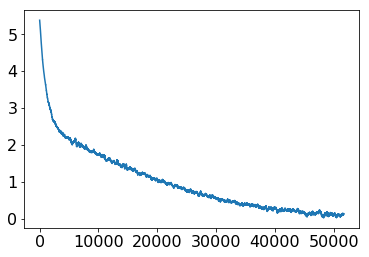

In [100]:
smoothing = True
log = True
window_length = 201
polyorder = 1

if smoothing and len(loss_hist) > window_length:
    smooth_loss_hist = savgol_filter(
        loss_hist,
        window_length=window_length,
        polyorder=polyorder)
else:
    smooth_loss_hist = loss_hist
if log:
    smooth_loss_hist = np.log1p(smooth_loss_hist)

ax = plt.gca()
ax.plot(smooth_loss_hist)

## Exploration

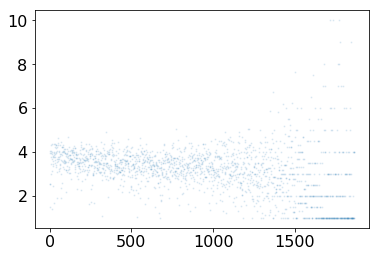

In [101]:
plt.scatter(np.arange(sc_fingerprint_dtm.n_genes), sc_fingerprint_dtm.empirical_fsd_mu_hi, s=1, alpha=0.1)

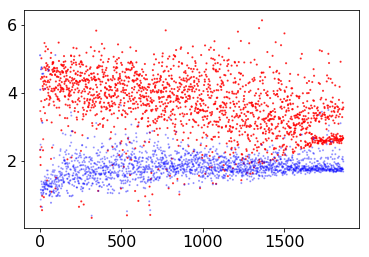

In [102]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")))
    empirical_mu = torch.tensor(sc_fingerprint_dtm.empirical_fsd_mu_hi).float().cuda().unsqueeze(-1)
    mu_hi = fsd_params_dict['mu_hi'].cpu().numpy()
    w_hi = fsd_params_dict['w_hi'].cpu().numpy()
    x = np.arange(sc_fingerprint_dtm.n_genes)
    
    rgba_colors_1 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
    rgba_colors_1[:, 0] = 1.0
    rgba_colors_1[:, 3] = w_hi[:, 0]

    rgba_colors_2 = np.zeros((sc_fingerprint_dtm.n_genes, 4))
    rgba_colors_2[:, 2] = 1.0
    rgba_colors_2[:, 3] = w_hi[:, 1]

    plt.scatter(x, mu_hi[:, 0], marker='.', s=5, color=rgba_colors_1)
    plt.scatter(x, mu_hi[:, 1], marker='.', s=5, color=rgba_colors_2)
    # plt.ylim([0, 5])

mean_e_obs: 0.000424358158285593
mean_e_hi (map): 0.0005654572829748007
e_hi_z: 4694
e_obs_z: 4711
mu_e_hi (prior): 0.0015723169781267643
phi_e_hi (prior): 1.020440697669983
p_zero_e_hi (prior): 0.6670829653739929
mean_e_hi (prior): 0.0014791954308748245


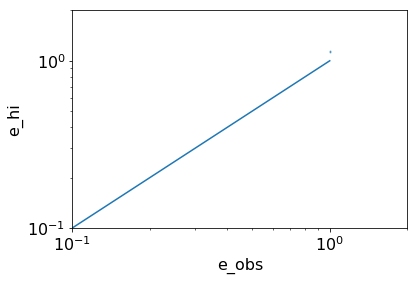

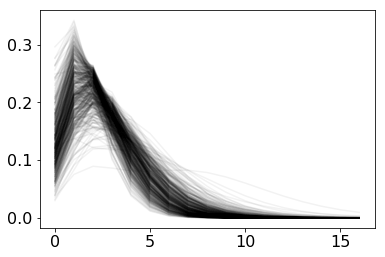

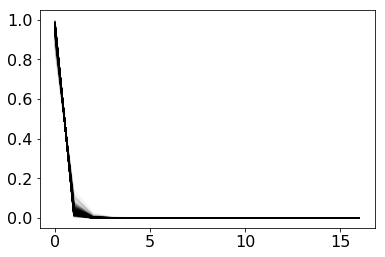

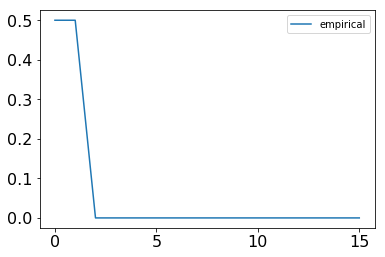

In [103]:
gene_index = 1600

sampler = PosteriorGeneExpressionSampler(model, device, dtype)
expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
    gene_index=gene_index,
    n_proposals_omega=20,
    n_particles_omega=10,
    n_particles_cell=10,
    n_particles_expression=10,
    cell_shard_size=500,
    run_mode="full",
    only_expressing_cells=False)
# expr_dict =  sampler.get_gene_expression_posterior_moments_summary(
#     gene_index=gene_index,
#     n_particles_omega=100,
#     n_particles_cell=1,
#     cell_shard_size=1000,
#     only_expressing_cells=False,
#     run_mode='full',
#     mode_estimation_strategy='lower_bound')

e_hi = expr_dict['e_hi_mean']

data = sampler._generate_single_gene_minibatch_data(
    gene_index, np.arange(0, sc_fingerprint_dtm.n_cells), 1)
zeta_nr = gene_expression_prior.forward(
    data['gene_index_tensor'],
    data['cell_index_tensor'],
    data['downsampling_rate_tensor'],
    data['total_obs_reads_per_cell_tensor'],
    data['cell_features_tensor'])
mu_e_hi_n, phi_e_hi_n, logit_p_zero_e_hi_n = gene_expression_prior.decode(zeta_nr)
e_hi_prior_dist = ZeroInflatedNegativeBinomial(
    logit_zero=logit_p_zero_e_hi_n,
    mu=mu_e_hi_n,
    phi=phi_e_hi_n)

e_obs = np.asarray(sc_fingerprint_dtm.sparse_count_matrix_csc[:, gene_index].todense()).squeeze(1)
mean_e_obs = np.mean(e_obs)
mean_e_hi = np.mean(e_hi)
e_hi_z = np.sum(e_hi == 0)
e_obs_z = np.sum(e_obs == 0)

print('mean_e_obs:', mean_e_obs)
print('mean_e_hi (map):', mean_e_hi)
print('e_hi_z:', e_hi_z)
print('e_obs_z:', e_obs_z)
print('mu_e_hi (prior):', mu_e_hi_n.mean().item())
print('phi_e_hi (prior):', phi_e_hi_n.mean().item())
print('p_zero_e_hi (prior):', torch.sigmoid(logit_p_zero_e_hi_n).mean().item())
print('mean_e_hi (prior):', e_hi_prior_dist.mean.mean().item())



fig = plt.figure()
plt.scatter(e_obs, e_hi, s=1, alpha=0.5)
plt.plot([0.1, np.max(e_obs)], [0.1, np.max(e_obs)])
plt.xlabel('e_obs', fontsize=16)
plt.ylabel('e_hi', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.1, 2*np.max(e_obs)))
plt.ylim((0.1, 2*np.max(e_obs)))

n_posterior_samples = 500
cell_index_array = np.zeros((n_posterior_samples,), dtype=np.int)
gene_index_array = gene_index * np.ones_like(cell_index_array)
cell_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
gene_sampling_site_scale_factor_array = np.ones_like(cell_index_array)
single_gene_mb_data = sc_fingerprint_dtm.generate_torch_minibatch_data(
    cell_index_array,
    gene_index_array,
    cell_sampling_site_scale_factor_array,
    gene_sampling_site_scale_factor_array)
guide_trace = poutine.trace(model.guide).get_trace(single_gene_mb_data)
fsd_params_dict = fsd_codec.decode(guide_trace.nodes["fsd_xi_nq"]["value"])
dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict)
p_lo = dist_lo.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()
p_hi = dist_hi.log_prob(torch.arange(0, sc_fingerprint_dtm.max_family_size + 1).float().cuda()).detach().cpu().exp().numpy()

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_hi[i, :], alpha=0.05, color='black')

fig = plt.figure()
for i in range(n_posterior_samples):
    plt.plot(p_lo[i, :], alpha=0.05, color='black')


collapsed_slice = gene_index + sc_fingerprint_dtm.n_genes * np.arange(sc_fingerprint_dtm.n_cells)
empircal_fsd = np.asarray(
    sc_fingerprint_dtm.sc_fingerprint_base.collapsed_csr_fingerprint_matrix[collapsed_slice, :].todense())
empircal_fsd = empircal_fsd / (1e-12 + np.sum(empircal_fsd, -1)[:, None])
empircal_fsd = np.sum(empircal_fsd, 0)
empircal_fsd = empircal_fsd / np.sum(empircal_fsd)

plt.figure()
plt.plot(empircal_fsd, label='empirical')
# plt.plot(model_fsd, label='model')
plt.legend()

(0, 2.5)

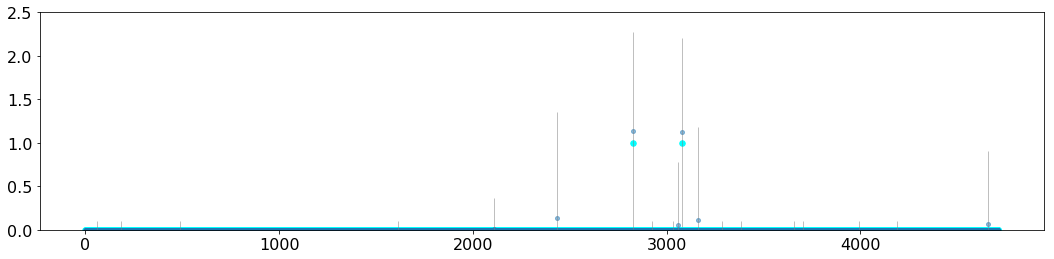

In [104]:
plt.figure(figsize=(18,4))

err = 3 * expr_dict['e_hi_std']
plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), e_obs, marker='o', color='cyan', s=30)
plt.errorbar(np.arange(0, sc_fingerprint_dtm.n_cells),
             expr_dict['e_hi_mean'],
             barsabove=True, elinewidth=1, lw=0,
             marker='.', ecolor='gray', markersize=8,
             yerr=err, alpha=0.5)
plt.ylim((0, 2.5 * np.max(expr_dict['e_hi_map'])))
# plt.scatter(np.arange(0, sc_fingerprint_dtm.n_cells), expr_dict['e_hi_mean'], marker='x', color='red', s=8)


In [76]:
np.any((e_hi > 0) & (e_obs == 0))

False

Text(0.5, 0, '$e_\\mathrm{obs}$')

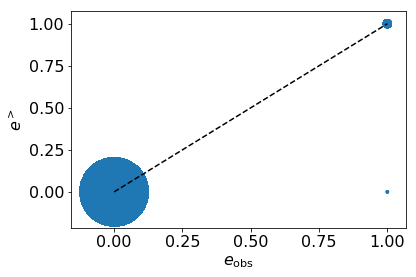

In [42]:
from collections import Counter
x_vals = e_obs
y_vals = expr_dict['e_hi_map']
combos = list(zip(x_vals, y_vals))
weight_counter = Counter(combos)
weights = [weight_counter[(x_vals[i], y_vals[i])] for i, _ in enumerate(x_vals)]


plt.scatter(x_vals, y_vals, s=weights, alpha=0.7)
plt.plot([0, np.max(x_vals)], [0, np.max(x_vals)], '--', color='black')
plt.ylabel(r'$e^>$', fontsize=16)
plt.xlabel(r'$e_\mathrm{obs}$', fontsize=16)

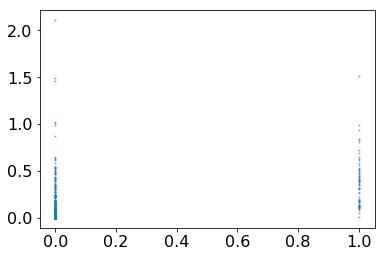

In [43]:
plt.scatter(
    e_hi,
    e_hi_prior_dist.mean.detach().cpu().numpy(), s=1, alpha=0.5)

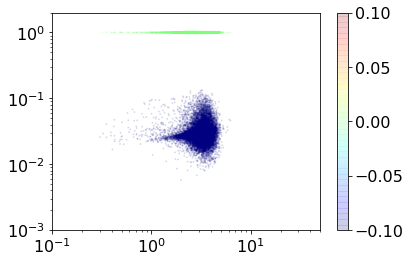

In [650]:
with torch.no_grad():
    fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc_gq"))
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_params_dict, downsampling_rate_tensor=None)
    mu_lo = dist_lo.mean.cpu().numpy()
    mu_hi = dist_hi.mean.cpu().numpy()
    phi_lo = fsd_params_dict['phi_lo'].squeeze(-1).cpu().numpy()
    
assignments = torch.argmin(
    (fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")).unsqueeze(-1)
     - fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq")).permute(-1, -2)).pow(2).sum(1), dim=-1).detach().cpu().numpy()

plt.scatter(mu_hi.squeeze(), mu_lo.squeeze(), s=1, alpha=0.1, c=assignments, cmap=plt.cm.jet)
plt.scatter(mu_hi.squeeze(), phi_lo.squeeze(), s=1, alpha=0.1, c=assignments, cmap=plt.cm.jet)
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-3, 2.))
plt.xlim((0.1, 50)) 
plt.colorbar()

In [562]:
# mu_e_hi_g, phi_e_hi_g, logit_p_zero_e_hi_g = model._decode_e_hi_zeta(
#     pyro.param("e_hi_zeta_posterior_loc_gr"))
# logit_p_zero_e_hi = logit_p_zero_e_hi_g.detach().cpu().numpy()
# _ = plt.hist(logit_p_zero_e_hi, bins=400)

In [563]:
# plt.scatter(np.log(mu_e_hi_g.detach().cpu().numpy()), logit_p_zero_e_hi_g.detach().cpu().numpy(), alpha=0.1, s=1)

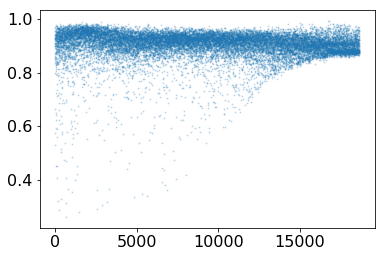

In [564]:
from pyro_extras import get_log_prob_compl

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq"))
    zero = torch.tensor(0, device=device, dtype=dtype)
    fsd_params_dict = fsd_codec.decode(xi_posterior)

    # get chimeric and real family size distributions
    fsd_lo_dist, fsd_hi_dist = fsd_codec.get_fsd_components(fsd_params_dict)

    # extract required quantities from the distributions
    mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
    mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
    log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
    log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
    log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
    log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
    p_obs_lo_g = log_p_obs_lo_g.exp()
    p_obs_hi_g = log_p_obs_hi_g.exp()
    
plt.scatter(np.arange(sc_fingerprint_dtm.n_genes), p_obs_hi_g.cpu().numpy(), alpha=0.2, s=1)

## Visualizing the distributions parameters $\xi$

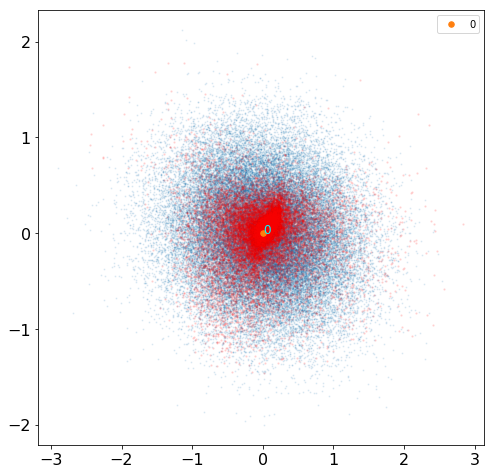

In [565]:
import pyro.distributions as dist
from pyro_extras import MixtureDistribution
from sklearn.decomposition import PCA

n_prior_samples = 50_000

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq")).detach().cpu().numpy()
    
    fsd_xi_prior_locs = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_prior_locs_kq"))
    fsd_xi_prior_scales = pyro.param("fsd_xi_prior_scales_kq")
    fsd_xi_prior_dist = model._get_fsd_xi_prior_dist(fsd_xi_prior_locs, fsd_xi_prior_scales)
    xi_prior = fsd_xi_prior_dist.sample((n_prior_samples,)).cpu().numpy()
    

pca = PCA(n_components=2)
xi_prior_pca_fit = pca.fit(xi_posterior)
xi_prior_pca = xi_prior_pca_fit.transform(xi_prior)
xi_posterior_pca = xi_prior_pca_fit.transform(xi_posterior)
xi_prior_locs_pca = xi_prior_pca_fit.transform(pyro.param("fsd_xi_prior_locs_kq").detach().cpu().numpy())


fig = plt.figure(figsize=(8, 8))
plt.scatter(xi_prior_pca[:, 0], xi_prior_pca[:, 1], alpha=0.1, s=1)
plt.scatter(xi_posterior_pca[:, 0], xi_posterior_pca[:, 1], alpha=0.1, s=2, color='red')
for j in range(model.fsd_gmm_num_components):
    plt.scatter(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], s=30, marker='o', label=str(j))
    plt.text(xi_prior_locs_pca[j, 0], xi_prior_locs_pca[j, 1], str(j), color='cyan', size=12)
plt.legend()


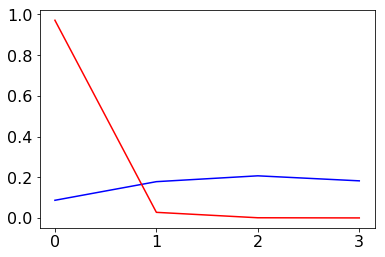

In [566]:
fig = plt.figure()

for fsd_gmm_comp_idx in range(1):
    fsd_xi = pyro.param("fsd_xi_prior_locs_kq")[fsd_gmm_comp_idx, :]
    dist_lo, dist_hi = fsd_codec.get_fsd_components(fsd_codec.decode(fsd_xi), None)
    max_fs = sc_fingerprint_dtm.max_family_size + 1

    p_hi = dist_hi.log_prob(torch.arange(0, max_fs / 5).float().cuda()).detach().cpu().exp().numpy().flatten()
    p_lo = dist_lo.log_prob(torch.arange(0, max_fs / 5).float().cuda()).detach().cpu().exp().numpy().flatten()
    plt.plot(p_hi, color='blue')
    plt.plot(p_lo, color='red')
#     plt.yscale('log')
    # plt.plot(p_hi, color='blue', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map_k")[fsd_gmm_comp_idx].item()))
    # plt.plot(p_lo, color='red', alpha=np.sqrt(pyro.param("fsd_xi_prior_weights_map_k")[fsd_gmm_comp_idx].item()))

## Save Model

In [61]:
model_output_path = os.path.join(
    output_path,
    f"{dataset_name}_{sc_fingerprint_dtm.n_genes}_genes_marginalized.pyro")
pyro.get_param_store().save(model_output_path)

## Extract and save gene expression posterior

In [62]:
sampler = PosteriorGeneExpressionSampler(model, device, dtype)
n_proposals_omega = 30
n_particles_omega = 10
n_particles_cell = 20
n_particles_expression = 20
cell_shard_size = 500
run_mode = "full"
only_expressing_cells = False
log_frequency = 10

In [ ]:
e_hi_map = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.int)
e_hi_mean = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)
e_hi_std = np.zeros((sc_fingerprint_dtm.n_cells, sc_fingerprint_dtm.n_genes), dtype=np.float32)

t0 = time.time()

for i_gene in range(sc_fingerprint_dtm.n_genes):
#     expr_dict = sampler.get_gene_expression_posterior_moments_summary(
#         gene_index=i_gene,
#         n_particles_omega=n_particles_omega,
#         n_particles_cell=n_particles_cell,
#         cell_shard_size=cell_shard_size,
#         run_mode=run_mode,
#         only_expressing_cells=only_expressing_cells)
    
    adaptive_cell_shard_size = cell_shard_size
    expr_dict = None
    
    while True:
        try:
            expr_dict = sampler.get_gene_expression_posterior_sampling_summary(
                gene_index=i_gene,
                n_proposals_omega=n_proposals_omega,
                n_particles_omega=n_particles_omega,
                n_particles_cell=n_particles_cell,
                n_particles_expression=n_particles_expression,
                cell_shard_size=adaptive_cell_shard_size,
                run_mode=run_mode,
                only_expressing_cells=only_expressing_cells)
        except RuntimeError:
            logging.warning("CUDA out of memory -- reducing cell shard size and retrying...")
            adaptive_cell_shard_size = int(np.ceil(adaptive_cell_shard_size / 2))
        
        if expr_dict is not None:
            break
            
        if adaptive_cell_shard_size == 1:
            raise RuntimeError("Buy a better GPU!")

    e_hi_map[:, i_gene] = expr_dict['e_hi_map']
    e_hi_mean[:, i_gene] = expr_dict['e_hi_mean']
    e_hi_std[:, i_gene] = expr_dict['e_hi_std']
    
    if i_gene % log_frequency == 0 and i_gene > 0:
        t1 = time.time()
        seconds_per_gene = (t1 - t0) / log_frequency
        t0 = t1
        logging.warning(f'Processing gene {i_gene+1}/{sc_fingerprint_dtm.n_genes} ({seconds_per_gene:.2f} s/gene)...')

# gene indices and cell barcodes
original_gene_indices = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.gene_idx_list)
cell_barcodes = np.asarray(sc_fingerprint_dtm.sc_fingerprint_base.barcode_list)

# save
np.save(e_hi_map_output_path, e_hi_map)
np.save(e_hi_mean_output_path, e_hi_mean)
np.save(e_hi_std_output_path, e_hi_std)
np.save(gene_indices_output_path, original_gene_indices)
np.save(cell_barcodes_output_path, cell_barcodes)

In [ ]:
from pyro_extras import get_log_prob_compl

with torch.no_grad():
    xi_posterior = fsd_codec.get_sorted_fsd_xi(pyro.param("fsd_xi_posterior_loc_gq"))
    zero = torch.tensor(0, device=device, dtype=dtype)
    fsd_params_dict = fsd_codec.decode(xi_posterior)

    # get chimeric and real family size distributions
    fsd_lo_dist, fsd_hi_dist = fsd_codec.get_fsd_components(fsd_params_dict)

    # extract required quantities from the distributions
    mu_fsd_lo_g = fsd_lo_dist.mean.squeeze(-1)
    mu_fsd_hi_g = fsd_hi_dist.mean.squeeze(-1)
    log_p_unobs_lo_g = fsd_lo_dist.log_prob(zero).squeeze(-1)
    log_p_unobs_hi_g = fsd_hi_dist.log_prob(zero).squeeze(-1)
    log_p_obs_lo_g = get_log_prob_compl(log_p_unobs_lo_g)
    log_p_obs_hi_g = get_log_prob_compl(log_p_unobs_hi_g)
    p_obs_lo_g = log_p_obs_lo_g.exp()
    p_obs_hi_g = log_p_obs_hi_g.exp()
    
np.save(os.path.join(output_path, "p_obs_hi.npy"), p_obs_hi_g.cpu().numpy())
np.save(os.path.join(output_path, "p_obs_lo.npy"), p_obs_lo_g.cpu().numpy())

In [96]:
# mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(1, 10, 15)
# trace = poutine.trace(model.model).get_trace(mb_data)
# print(trace.format_shapes())

# with torch.no_grad():
#     # adapt model parameters to downsampled dataset
#     fsd_params_dict = fsd_codec.decode(pyro.param("fsd_xi_posterior_loc"))

#     kappa = 0.25
#     downsampled_fsd_params_dict = dict()
#     downsampled_fsd_params_dict['phi_lo'] = fsd_params_dict['phi_lo']
#     downsampled_fsd_params_dict['phi_hi'] = fsd_params_dict['phi_hi']
#     downsampled_fsd_params_dict['w_lo'] = fsd_params_dict['w_lo']
#     downsampled_fsd_params_dict['w_hi'] = fsd_params_dict['w_hi']
#     downsampled_fsd_params_dict['mu_lo'] = kappa * fsd_params_dict['mu_lo']
#     downsampled_fsd_params_dict['mu_hi'] = kappa * fsd_params_dict['mu_hi']
#     downsampled_fsd_xi_posterior_loc = fsd_codec.encode(downsampled_fsd_params_dict)
    
# pyro.get_param_store()['fsd_xi_posterior_loc'].data.copy_(downsampled_fsd_xi_posterior_loc.data)

# # reset e_hi parameters to the initial estimate
# from pyro_extras import logit
# with torch.no_grad():
#     pyro.get_param_store()._params['mu_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_mu_e_hi).log())
#     pyro.get_param_store()._params['phi_e_hi'].data.copy_(torch.tensor(sc_fingerprint_datastore.estimated_phi_e_hi).log())
#     pyro.get_param_store()._params['logit_p_zero_e_hi'].data.copy_(logit(torch.tensor(sc_fingerprint_datastore.estimated_p_zero_e_hi)))

# pyro.get_param_store()._params['beta_c'].data.copy_(torch.tensor(1.).log())

In [ ]:
# print_loss_frequency = 50
# checkpoint_frequency = 1_000

# mb_loss_list = []
# fsd_abs_res_list = []
# loss_scale_factor = 1. / (sc_fingerprint_datastore.n_cells * sc_fingerprint_datastore.n_genes)
# prev_fsd_xi_posterior_loc = torch.zeros(
#     (sc_fingerprint_datastore.n_genes, fsd_codec.total_fsd_params),
#     dtype=dtype, device=device)

# t0 = time.time()

# while i_iter < n_training_iters:
#     # generate stratified minibatch
#     mb_data = sc_fingerprint_datastore.generate_stratified_sample_torch(
#         minibatch_genes_per_gene_group,
#         minibatch_expressing_cells_per_gene,
#         minibatch_silent_cells_per_gene)

#     # SVI update
#     mb_loss = svi.step(mb_data)
#     i_iter += 1
        
#     # bookkeeping, history tracking, etc.
#     mb_loss_per_cell_gene = loss_scale_factor * mb_loss
#     mb_loss_list.append(mb_loss_per_cell_gene)
    
#     # calculate change in fsd parameters
#     new_fsd_xi_posterior_loc = pyro.param("fsd_xi_posterior_loc_gq").clone().detach()
#     xi_posterior_abs_res_mean = torch.mean((new_fsd_xi_posterior_loc - prev_fsd_xi_posterior_loc).abs()).item()
#     prev_fsd_xi_posterior_loc = new_fsd_xi_posterior_loc    
#     fsd_abs_res_list.append(1_000 * xi_posterior_abs_res_mean)
    
#     if i_iter % print_loss_frequency == 0 and i_iter > 0:
#         t1 = time.time()
        
#         mb_loss_mean, mb_loss_std = np.mean(mb_loss_list), np.std(mb_loss_list)
#         fsd_abs_res_mean, fsd_abs_res_std = np.mean(fsd_abs_res_list), np.std(fsd_abs_res_list)
#         phi_e_hi_mean, phi_e_hi_std = torch.mean(pyro.param("phi_e_hi_g")).item(), torch.std(pyro.param("phi_e_hi_g")).item()
#         phi_e_hi_max, phi_e_hi_min = torch.max(pyro.param("phi_e_hi_g")).item(), torch.min(pyro.param("phi_e_hi_g")).item()
#         logit_p_zero_e_hi_mean, logit_p_zero_e_hi_std = (
#             torch.mean(pyro.param("logit_p_zero_e_hi_g")).item(),
#             torch.std(pyro.param("logit_p_zero_e_hi_g")).item())
#         logit_p_zero_e_hi_max, logit_p_zero_e_hi_min = (
#             torch.max(pyro.param("logit_p_zero_e_hi_g")).item(),
#             torch.min(pyro.param("logit_p_zero_e_hi_g")).item())

#         mb_loss_list = []
#         fsd_abs_res_list = []
#         print(f'Iteration number: {i_iter}, loss: {mb_loss_mean:.3f} +- {mb_loss_std:.3f}, ' +
#               f'fsd_abs_res: {fsd_abs_res_mean:.4f} +- {fsd_abs_res_std:.4f}, ' +
#               f'time: {(t1 - t0):.3f}s')
#         print(f'alpha_c: {pyro.param("alpha_c").item():.3f}')
#         print(f'beta_c: {pyro.param("beta_c").item():.3f}')
#         print(f'phi_e_hi: {phi_e_hi_mean:.4f} +- {phi_e_hi_std:.3f} [{phi_e_hi_min:.4f}, {phi_e_hi_max:.4f}]')
#         print(f'logit_p_zero_e_hi: {logit_p_zero_e_hi_mean:.4f} +- ' \
#               + f'{logit_p_zero_e_hi_std:.4f} [{logit_p_zero_e_hi_min:.4f}, {logit_p_zero_e_hi_max:.4f}]')
#         t0 = t1
#     loss_hist.append(mb_loss_per_cell_gene)

#     if i_iter % checkpoint_frequency == 0:
#         logging.warning("Checkpointing the latest model parameters...")
#         checkpoint_model(checkpoint_path)

In [672]:
w = np.random.randn(5, 500)
u = np.random.randn(100, 5)
x = np.matmul(u, w) + 0.1 * np.random.randn(100, 500)

In [680]:
from sklearn.decomposition import TruncatedSVD, PCA

In [710]:
svd = TruncatedSVD(n_components=10)
pca = PCA(n_components=10)

In [711]:
f = svd.fit(x)

In [712]:
f.components_.shape

(10, 500)

In [706]:
np.matmul(f.transform(x), f.components_) - x

array([[-5.59552404e-14,  6.94999613e-14, -9.08162434e-14, ...,
        -5.32907052e-15,  2.21489493e-14,  9.36750677e-17],
       [ 1.45217172e-13,  1.03431153e-13,  1.11022302e-16, ...,
        -1.33226763e-15, -5.55111512e-15,  5.88418203e-15],
       [-8.17401702e-15,  1.63202785e-14, -3.10862447e-15, ...,
        -4.21884749e-15,  2.88657986e-15,  4.44089210e-16],
       ...,
       [-7.99360578e-15, -4.92939023e-14,  7.88258347e-15, ...,
        -4.44089210e-15,  8.88178420e-16,  3.55271368e-15],
       [-1.97619698e-14, -1.28230759e-14,  3.99680289e-15, ...,
        -2.99760217e-15,  5.32907052e-15, -4.44089210e-15],
       [-4.88498131e-15, -5.55111512e-15, -1.82076576e-14, ...,
         8.88178420e-16,  3.55271368e-15,  1.99840144e-15]])